In [12]:
from modules.midiscoretools import render_wav_with_fluidsynth, Frame
from programs.createRefData import  midi2frameskeleton
import soundfile as sf
import numpy as np


In [13]:
# just for the notebook
from IPython.display import Audio, display
import librosa #just for converting to mel to dB
import matplotlib.pyplot as plt

In [14]:
# Set your desired parameters
input_midi = "scores/BartokRFD1/VarData/Var01/BartokRFD1v01.mid"
wavefile = "scores/BartokRFD1/VarData/Var01/BartokRFD1v01.wav"
output_mel = "scores/BartokRFD1/VarData/Var01/BartokRFD1v01.MEL.npz"
output_frames = "scores/BartokRFD1/VarData/Var01/BartokRFD1v01.frames.npz"
original_sample_rate=44100
sample_rate = 22050  # Hz
win_length=512
hop_length=256
n_mels=64
f_min=20  # Set this to your desired minimum frequency
f_max=sample_rate / 2  # Set this to your desired maximum frequency (we don't need freqs above 10K)


In [15]:
# midi 2 wav
# fluidsynth writes to wav file, so must write and then read from disk
render_wav_with_fluidsynth(input_midi, wavefile)
wave_data, sr = sf.read(wavefile)

# fluidsynth likes to generate stereo, but our midis are not multi channel (that I know of)
mono_wave_data = wave_data[:, 0]

FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'scores/BartokRFD1/VarData/Var01/BartokRFD1v01.wav'..


<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">listen</span>

In [16]:
#Audio(wave_data, sr)
print(f"Data type: {mono_wave_data.dtype}")
print(f"Data range: {np.min(mono_wave_data)} to {np.max(mono_wave_data)}")
print(f"Data shape: {mono_wave_data.shape}")

print(np.any(np.isnan(mono_wave_data)))  # Should be False
print(np.any(np.isinf(mono_wave_data)))  # Should be False
#Audio(data=wave_data.T, rate=sr) #if you want stereo, gotta transpose it!
Audio(data=mono_wave_data, rate=sr)

Data type: float64
Data range: -0.138763427734375 to 0.123748779296875
Data shape: (2473792,)
False
False


<span style="color:#0000AA;  font-size: 16px; font-weight: bold;  ">Compute mel_spectrogram</span> 

In [17]:
# Apply to your audio data
wave_data = mono_wave_data.astype(np.float32)

if original_sample_rate != sample_rate:
    wave_data = librosa.resample(wave_data, orig_sr=original_sample_rate, target_sr=sample_rate)

mel_spec = librosa.feature.melspectrogram(
        y=wave_data, 
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=win_length,
        hop_length=hop_length
    )


<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">visualize</span> 

In [18]:
mel_spec.shape

(64, 4832)

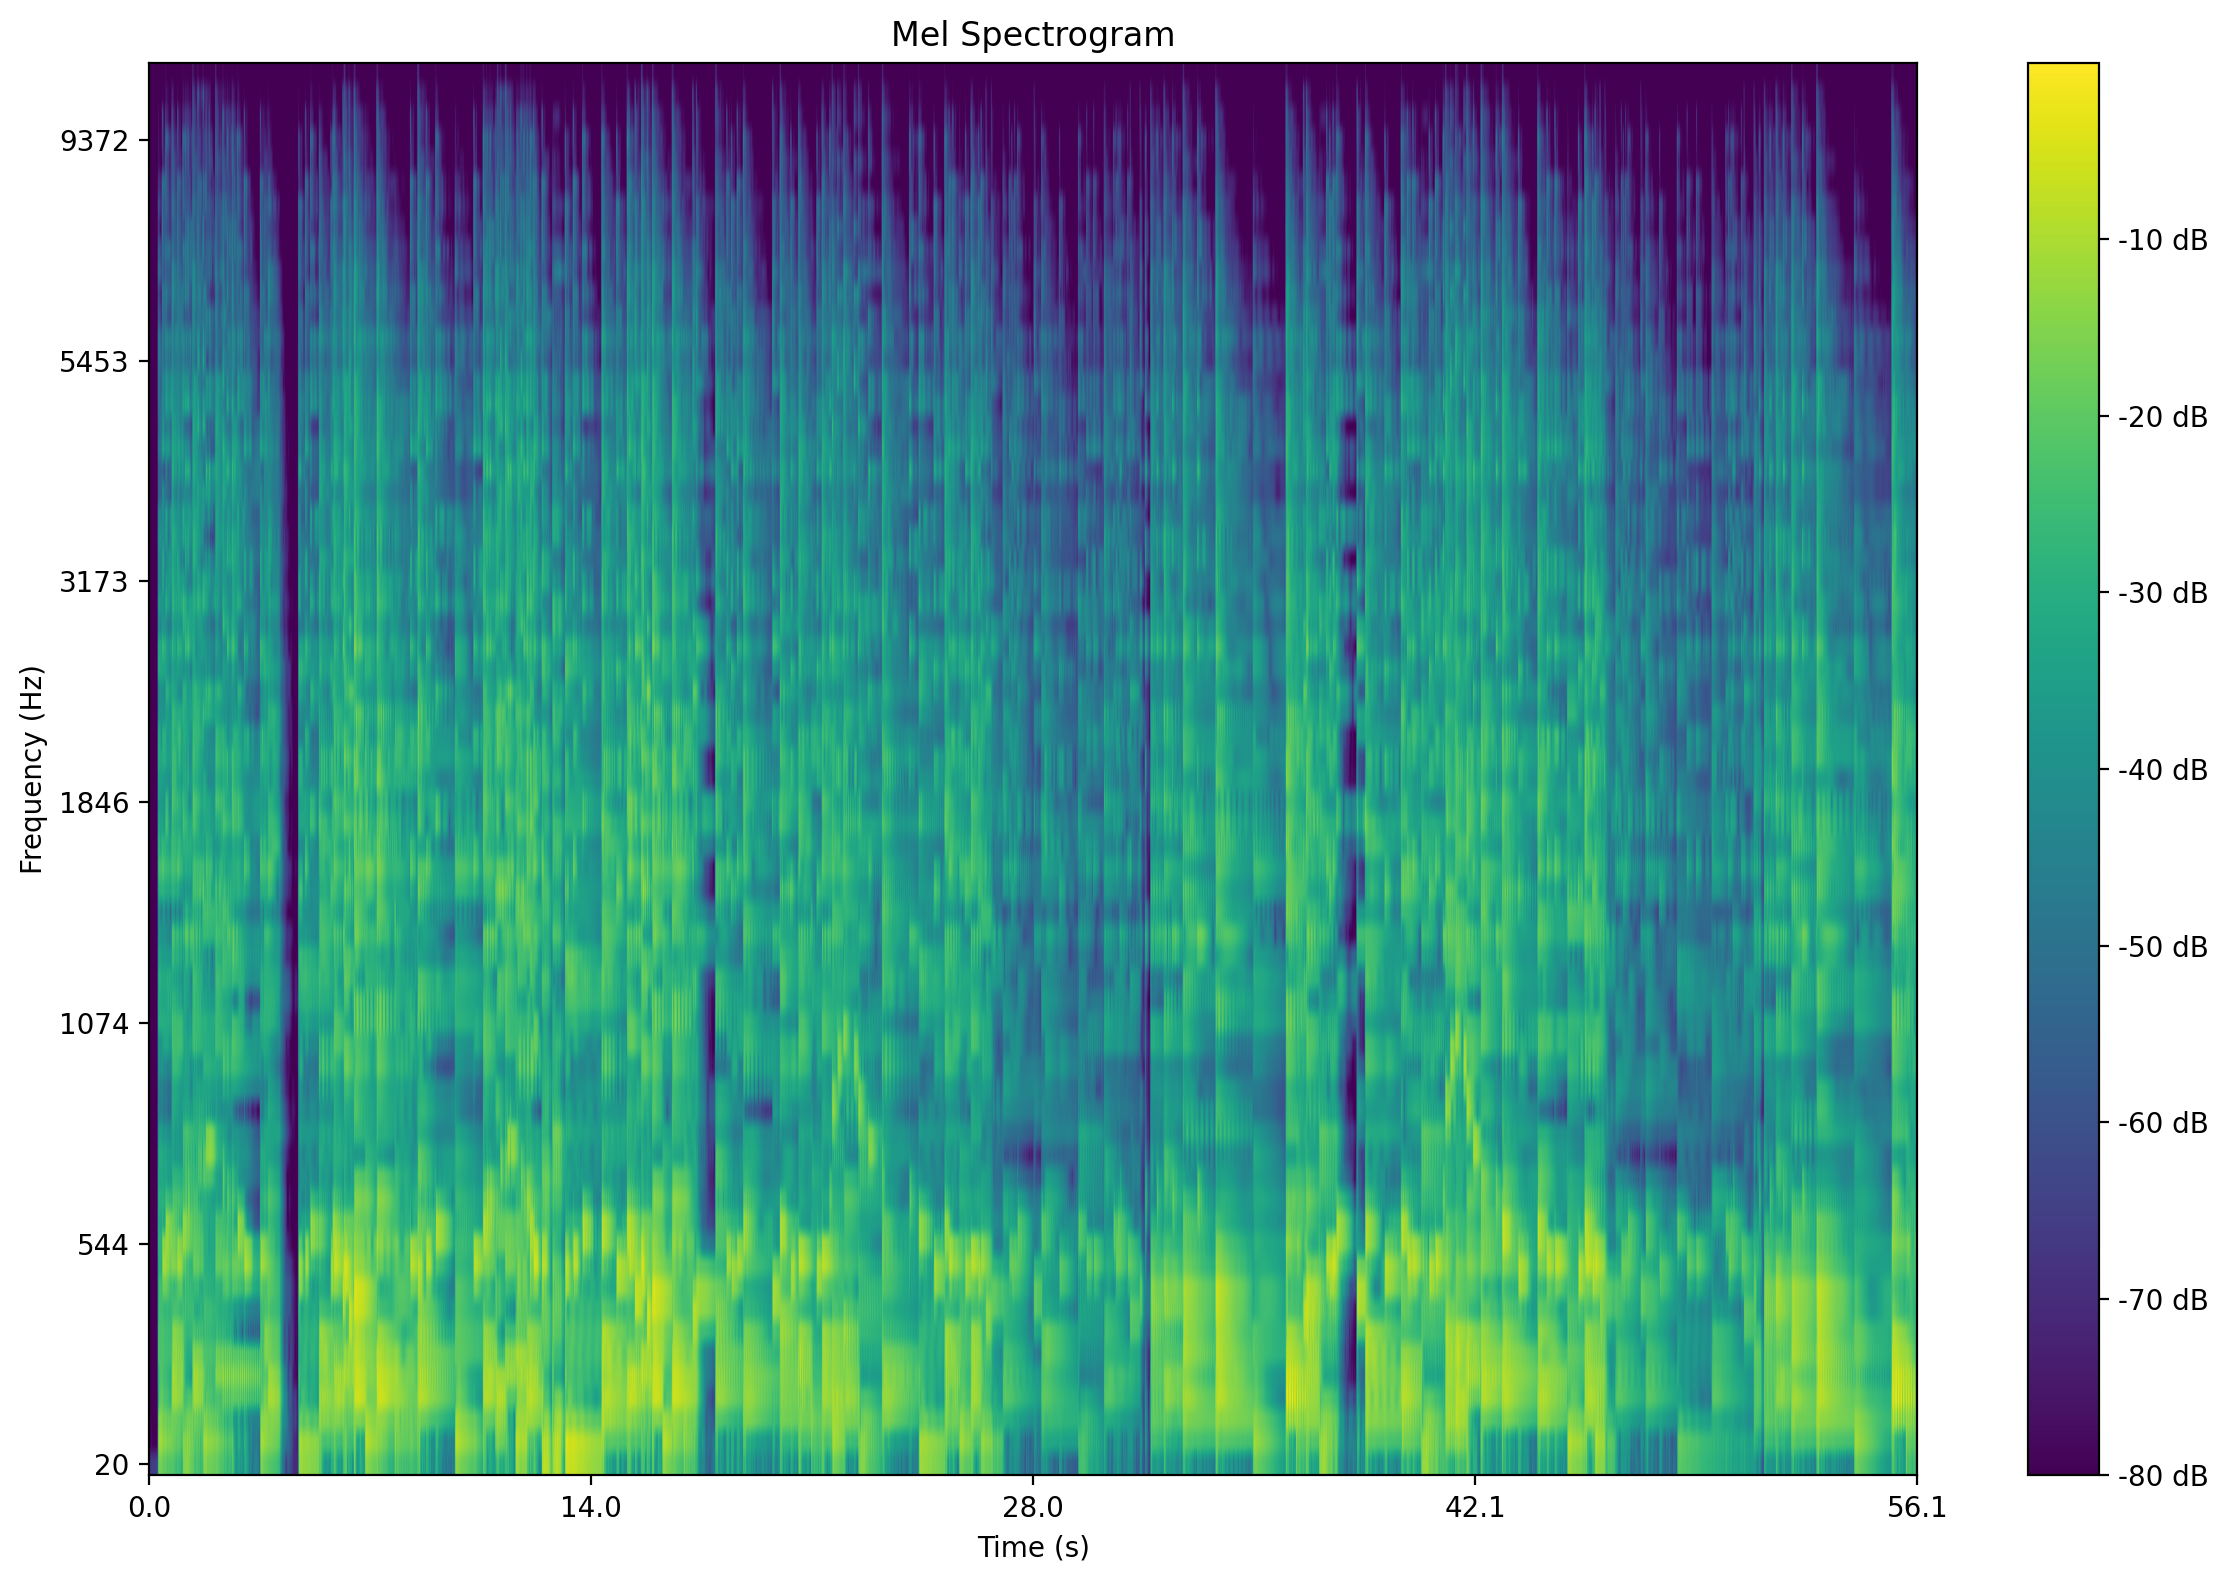

In [19]:

spec = mel_spec.squeeze()
# Convert to dB scale
spec_db = librosa.power_to_db(spec, ref=np.max)


# Get the sample rate and number of mel bins
sr = sample_rate  # Replace with your actual sample rate
n_mels = spec.shape[0]

# Calculate mel frequencies
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=f_min, fmax=f_max)

# Create the plot
plt.figure(figsize=(12, 8))
plt.imshow(spec_db, aspect='auto', origin='lower', cmap='viridis')

# Set y-axis labels
plt.yticks(np.arange(0, n_mels, 10), [f'{int(f)}' for f in mel_frequencies[::10]])
plt.ylabel('Frequency (Hz)')

# Set x-axis labels
time_ticks = np.linspace(0, spec.shape[1], 5)
time_labels = [f'{t:.1f}' for t in time_ticks * hop_length / sr]
plt.xticks(time_ticks, time_labels)
plt.xlabel('Time (s)')

plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [20]:
print(f'shape= {spec_db.shape}, max value= {np.max(spec_db)}')

shape= (64, 4832), max value= -2.384185791015625e-07


In [21]:
frameList=midi2frameskeleton(input_midi,sample_rate/win_length)

In [22]:
# Save ??
# np.savez(output_mel, data=spec_db)
# # Load the .npz file
# loaded_data = np.load(output_mel)
# # Access the array
# spec_db_loaded = loaded_data['data']

np.savez_compressed(output_mel, data=spec_db)
# Load the .npz file
loaded_compressed_data = np.load(output_mel)
# Access the array
spec_db_compressed_loaded = loaded_compressed_data['data']


Frame.save_frames(frameList, output_frames)
loaded_frames = Frame.load_frames(output_frames)
print(loaded_frames[0].to_dict())

{'num': 0, 'sTk': 0, 'sTm': 0.0, 'mTk': 10, 'mTm': 0.012, 'measure': nan, 'beat': nan, 'refframe': 0}
